## DATA PREPARATION
In this notebook we make the neccesary joins with the SQL Spark Motor to get the number of reviews, tips and checkins for the top 20 popular brands (the brands which are the most repetitive on the business table, 6K of 150K business in total).

We will only include data since 2010, because checkin and tips were implemented on 2009 in the Yelp App.

Because we don't have too much reviews and interactions we are gonna analize the monthly count of reviews+tips+checkins.

In [ ]:
#### INSTALLATION OF LIBRARIES
!sudo apt update
!sudo apt install openjdk-17-jdk -y
#!curl -JLO 'https://apache.osuosl.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz'
!tar xvf spark-3.3.1-bin-hadoop3.tgz
!mv spark-3.3.1-bin-hadoop3 /opt/spark
!pip install pyspark missingno findspark plotly wandb koalas

In [ ]:
#### LIBRARIES
import os
os.environ["JAVA_HOME"] = "/usr"
os.environ["SPARK_HOME"] = "/opt/spark"
#### BASIC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### SPARK
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import databricks.koalas as ks
spark = SparkSession.builder.master("local[*]").getOrCreate()

#### SETTINGS
%matplotlib inline
spark.sparkContext.setLogLevel("OFF")
ps.options.plotting.backend = 'matplotlib'

In [65]:
checkin = ks.read_json('./data/checkin.json', lines=True)
review = ks.read_json('./data/review.json', lines=True)
business = ks.read_json('./data/business.json', lines=True)
tip = ks.read_json('./data/tip.json', lines=True)

In [ ]:
ks.sql('''
    select count(distinct(business_id)) as business_count
    from {review}
    where business_id in (select business_id from {popular_brands_ids})
''')

In [96]:
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"1616 Chapala St, Ste 2","(None, None, None, None, None, None, None, Non...",Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",Santa Barbara,None,0,34.426679,-119.711197,"Abby Rappoport, LAC, CMQ",93101,7,5.0,CA
1,87 Grasso Plaza Shopping Center,"(None, None, None, None, None, None, None, Non...",mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",Affton,"(8:0-18:30, 0:0-0:0, 8:0-14:0, None, 8:0-18:30...",1,38.551126,-90.335695,The UPS Store,63123,15,3.0,MO
2,5255 E Broadway Blvd,"(None, None, None, None, None, None, None, Tru...",tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G...",Tucson,"(8:0-23:0, 8:0-22:0, 8:0-23:0, 8:0-22:0, 8:0-2...",0,32.223236,-110.880452,Target,85711,22,3.5,AZ
3,935 Race St,"(None, None, u'none', None, None, None, None, ...",MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",Philadelphia,"(7:0-21:0, 7:0-20:0, 7:0-21:0, 7:0-21:0, 7:0-2...",1,39.955505,-75.155564,St Honore Pastries,19107,80,4.0,PA
4,101 Walnut St,"(None, None, None, None, None, None, None, Tru...",mWMc6_wTdE0EUBKIGXDVfA,"Brewpubs, Breweries, Food",Green Lane,"(12:0-22:0, None, 12:0-22:0, 12:0-18:0, 16:0-2...",1,40.338183,-75.471659,Perkiomen Valley Brewery,18054,13,4.5,PA


In [67]:
popular_brands_names = ks.sql("select count(*), name from {business} group by name order by 1 desc limit 20")

In [68]:
popular_brands_ids = ks.sql('''
select business_id
from {business}
where name in (select name from {popular_brands_names})
''')

In [56]:
checkin_popular = ks.sql('''
select *
from {checkin}
where business_id in (select business_id from {popular_brands_ids})
''')

In [60]:
tip_popular = ks.sql('''
select business_id, date
from {tip}
where business_id in (select business_id from {popular_brands_ids})
''')

In [62]:
review_popular = ks.sql('''
select business_id, date
from {review}
where business_id in (select business_id from {popular_brands_ids})
''')

In [85]:
review_popular.shape

(133399, 2)

In [67]:
checkin_popular.info()

<class 'databricks.koalas.frame.DataFrame'>
Int64Index: 6492 entries, 0 to 6491
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  6492 non-null   object
 1   date         6492 non-null   object
dtypes: object(2)

In [68]:
checkin_popular_spark = checkin_popular.to_spark()

In [72]:
from pyspark.sql.functions import split, col
checkin_popular_spark_2 = checkin_popular_spark.select(split(col("date"),",").alias("date_array"),col("business_id"))
checkin_popular_spark_2.show()

+--------------------+--------------------+
|          date_array|         business_id|
+--------------------+--------------------+
|[2011-07-29 16:37...|--lqIzK-ZVTtgwiQM...|
|[2011-06-06 00:37...|-1zRvh3yjKAa2eYgg...|
|[2010-10-25 05:37...|-2BDt9OdGiBONysWC...|
|[2012-06-02 21:05...|-2CPhK6ik9ZBgFX_F...|
|[2011-09-23 18:00...|-2mctVTqFR5-DDCXK...|
|[2016-08-17 19:46...|-3725FZiIIYdwQtM4...|
|[2011-03-26 01:57...|-3Xl8nSBSjaPpftsS...|
|[2011-05-09 12:13...|-3dkEoYgH8AlUtBMZ...|
|[2012-01-05 05:16...|-6E_cla4lotruNasI...|
|[2010-06-14 03:35...|-6MEKOmFu6jckT3pr...|
|[2010-02-13 16:06...|-6kIZWnXPuDC6JiQJ...|
|[2010-03-27 16:44...|-6xYpkvG91ClVz31J...|
|[2010-07-27 20:24...|-7Rx5jVeQmlVoAU_o...|
|[2010-11-11 17:57...|-7UDKbg_8TL4LVuYR...|
|[2011-10-24 15:18...|-7_Wl2UGiuA7I5Lh0...|
|[2010-09-05 16:47...|-85kJMtb9wqNWDT8y...|
|[2010-07-22 17:48...|-8wGpH3gYkwHKLcpc...|
|[2012-05-30 15:36...|-99CauTgdResVER5N...|
|[2010-08-31 00:40...|-9yzQQ0d_rcOD2Czd...|
|[2010-07-23 22:51...|-A-5spZpPM

In [75]:
from pyspark.sql.functions import explode
# using select function applying
# explode on array column
checkin_popular_spark_3 = checkin_popular_spark_2.select(checkin_popular_spark_2.business_id,explode(checkin_popular_spark_2.date_array))
 
# printing the schema of the df2
checkin_popular_spark_3.printSchema()
 
# show df2
checkin_popular_spark_3.show()

root
 |-- business_id: string (nullable = true)
 |-- col: string (nullable = false)

+--------------------+--------------------+
|         business_id|                 col|
+--------------------+--------------------+
|--lqIzK-ZVTtgwiQM...| 2011-07-29 16:37:02|
|--lqIzK-ZVTtgwiQM...| 2011-10-24 16:00:29|
|--lqIzK-ZVTtgwiQM...| 2012-10-27 19:17:50|
|--lqIzK-ZVTtgwiQM...| 2013-05-13 22:03:28|
|--lqIzK-ZVTtgwiQM...| 2013-05-14 21:25:02|
|--lqIzK-ZVTtgwiQM...| 2013-05-28 22:18:02|
|--lqIzK-ZVTtgwiQM...| 2014-12-08 17:31:29|
|--lqIzK-ZVTtgwiQM...| 2015-03-02 18:41:47|
|--lqIzK-ZVTtgwiQM...| 2016-01-15 17:49:03|
|--lqIzK-ZVTtgwiQM...| 2016-03-06 16:55:09|
|--lqIzK-ZVTtgwiQM...| 2016-07-06 20:40:56|
|--lqIzK-ZVTtgwiQM...| 2017-03-09 02:16:11|
|--lqIzK-ZVTtgwiQM...| 2017-04-25 22:19:12|
|--lqIzK-ZVTtgwiQM...| 2017-09-25 15:09:54|
|--lqIzK-ZVTtgwiQM...| 2019-01-07 17:39:16|
|--lqIzK-ZVTtgwiQM...| 2019-05-30 22:26:48|
|--lqIzK-ZVTtgwiQM...| 2019-07-22 16:12:14|
|--lqIzK-ZVTtgwiQM...| 2019-09-07 2

In [76]:
checkin_popular_normalized = checkin_popular_spark_3.to_koalas()

In [86]:
checkin_popular_normalized.head(1)

,business_id,col
0,--lqIzK-ZVTtgwiQM63XgQ,2011-07-29 16:37:02


In [87]:
checkin_popular_normalized['date'] = ks.to_datetime(checkin_popular_normalized['col'], format='%Y-%m-%d %H:%M:%S')
checkin_popular_normalized = checkin_popular_normalized.drop('col', axis=1)
checkin_popular_normalized.head(1)

/opt/spark/python/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


,business_id,date
0,--lqIzK-ZVTtgwiQM63XgQ,2011-07-29 16:37:02


In [89]:
review_popular['date'] = ks.to_datetime(review_popular['date'], format='%Y-%m-%d %H:%M:%S')

/opt/spark/python/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [91]:
tip_popular['date'] = ks.to_datetime(tip_popular['date'], format='%Y-%m-%d %H:%M:%S')

/opt/spark/python/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [92]:
checkin_p = checkin_popular_normalized.to_pandas()
review_p = review_popular.to_pandas()
tip_p = tip_popular.to_pandas()

In [93]:
checkin_p.to_csv('./data/checkin_timeseries.csv', index=False)
review_p.to_csv('./data/review_timeseries.csv', index=False)
tip_p.to_csv('./data/tip_timeseries.csv', index=False)

In [2]:
import pandas as pd
checkin_p = pd.read_csv('../data/checkin_timeseries.csv', parse_dates=['date'])
review_p = pd.read_csv('../data/review_timeseries.csv', parse_dates=['date'])
tip_p = pd.read_csv('../data/tip_timeseries.csv', parse_dates=['date'])

In [3]:
checkin_p['m_y'] = checkin_p['date'].apply(lambda x: "%d/%d" % (x.month, x.year))
checkin_p = pd.DataFrame(checkin_p.groupby(['m_y', 'business_id']).size())
checkin_p['data'] = checkin_p.index
checkin_p['month'] = checkin_p['data'].apply(lambda x: x[0])
checkin_p['business_id'] = checkin_p['data'].apply(lambda x: x[1])
checkin_p = checkin_p.drop('data', axis=1)
checkin_p = checkin_p.reset_index(drop=True)
checkin_p = checkin_p.rename(columns={0: 'count'})
checkin_p.head()

,count,month,business_id
0,1,1/2010,29ThPh6IA69V-SfcwfV9Dg
1,1,1/2010,2Kqq7D6oj4FNF_9JmVjQJw
2,1,1/2010,2kt2oK-zgshowfiV3ZQl0Q
3,2,1/2010,48hwr-F1xEFfHdTD1ueE2A
4,2,1/2010,6EskDOVYwOFPYHYt7SY-DQ


In [4]:
review_p['m_y'] = review_p['date'].apply(lambda x: "%d/%d" % (x.month, x.year))
review_p = pd.DataFrame(review_p.groupby(['m_y', 'business_id']).size())
review_p['data'] = review_p.index
review_p['month'] = review_p['data'].apply(lambda x: x[0])
review_p['business_id'] = review_p['data'].apply(lambda x: x[1])
review_p = review_p.drop('data', axis=1)
review_p = review_p.reset_index(drop=True)
review_p = review_p.rename(columns={0: 'count'})
review_p.head()

,count,month,business_id
0,1,1/2006,3yyRANNTMIyS2jgGHeEzxA
1,1,1/2006,K2G-FsUMEV1gqWsLWsKzGQ
2,1,1/2006,aT0FhdLMRjUkJjjANFz7ZA
3,1,1/2007,1sZKO790Q6C4aV9PKmtWeA
4,1,1/2007,JyYT5phFLg3BESNL-WXf4Q


In [5]:
tip_p['m_y'] = tip_p['date'].apply(lambda x: "%d/%d" % (x.month, x.year))
tip_p = pd.DataFrame(tip_p.groupby(['m_y', 'business_id']).size())
tip_p['data'] = tip_p.index
tip_p['month'] = tip_p['data'].apply(lambda x: x[0])
tip_p['business_id'] = tip_p['data'].apply(lambda x: x[1])
tip_p = tip_p.drop('data', axis=1)
tip_p = tip_p.reset_index(drop=True)
tip_p = tip_p.rename(columns={0: 'count'})
tip_p.head()

,count,month,business_id
0,1,1/2010,2zSQu6_cLgWAVbZ2LbSLBA
1,1,1/2010,4bM_dsAYj4AxYL9NjVrp7A
2,1,1/2010,6EskDOVYwOFPYHYt7SY-DQ
3,2,1/2010,OPhWuFj83RDS9O1qU21X8Q
4,1,1/2010,WRh6AOkXFl1qtnlCYUUQ6Q


In [6]:
print(checkin_p.shape)
print(review_p.shape)
print(tip_p.shape)

(192996, 3)
(110083, 3)
(21724, 3)


In [61]:
full_count = pd.merge(checkin_p, review_p, on=['month', 'business_id'], how='outer')
full_count = pd.merge(full_count, tip_p, on=['month', 'business_id'], how='outer')
full_count = full_count.fillna(0)
full_count['total'] = full_count['count_x'] + full_count['count_y'] + full_count['count']
full_count = full_count.drop(['count_x', 'count_y', 'count'], axis=1)
full_count.head()

,month,business_id,total
0,1/2010,29ThPh6IA69V-SfcwfV9Dg,1.0
1,1/2010,2Kqq7D6oj4FNF_9JmVjQJw,1.0
2,1/2010,2kt2oK-zgshowfiV3ZQl0Q,1.0
3,1/2010,48hwr-F1xEFfHdTD1ueE2A,2.0
4,1/2010,6EskDOVYwOFPYHYt7SY-DQ,3.0


In [69]:
full_count.to_csv('./data/full_count.csv', index=False)

In [70]:
full_count_k = ks.from_pandas(full_count)

In [73]:
popular_brands_ids_and_names = ks.sql('''
select business_id, name
from {business}
where name in (select name from {popular_brands_names})
''')

In [76]:
final_table = ks.sql('''
select month, name, sum(total) as total
from {full_count_k}
join {popular_brands_ids_and_names} on {full_count_k}.business_id = {popular_brands_ids_and_names}.business_id
group by month, name
order by name, month
''')

In [78]:
final_table_pandas = final_table.to_pandas()

In [80]:
final_table_pandas.to_csv('./data/final_table_for_forecasting.csv', index=False)

In [81]:
final_table_pandas['month'] = pd.to_datetime(final_table_pandas['month'], format='%m/%Y')

In [ ]:
final_table_pandas.set_index('month', inplace=True)

In [82]:
final_table_pandas

,month,name,total
0,2009-01-01,Burger King,2.0
1,2010-01-01,Burger King,7.0
2,2011-01-01,Burger King,33.0
3,2012-01-01,Burger King,79.0
4,2013-01-01,Burger King,130.0
...,...,...,...
3359,2017-09-01,Wendy's,130.0
3360,2018-09-01,Wendy's,149.0
3361,2019-09-01,Wendy's,171.0
3362,2020-09-01,Wendy's,134.0


In [104]:
final_table_pandas.groupby('name').agg({'total': 'sum'}).sort_values(by='total', ascending=False)

,total
name,
Starbucks,229914.0
McDonald's,59882.0
Wawa,48561.0
Dunkin',46448.0
Chick-fil-A,41966.0
Walgreens,34151.0
CVS Pharmacy,28599.0
Taco Bell,25736.0
Wendy's,18853.0


In [109]:
real_final_table = final_table_pandas.pivot_table(index='month', columns='name', values='total')

In [111]:
real_final_table.to_csv('./data/forecasting.csv')

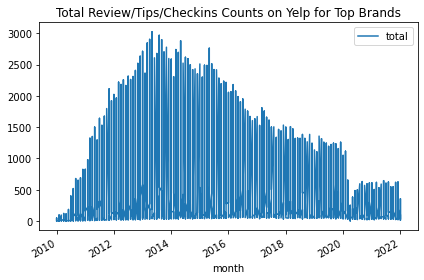

In [119]:
import matplotlib.pyplot as plt
final_table_pandas['2010-01-01':].plot(title = 'Total Review/Tips/Checkins Counts on Yelp for Top Brands')
plt.tight_layout()
plt.show()